<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [1]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !pip install kaggle

In [2]:
# ! pip install category_encoders

In [3]:
import pandas as pd
import numpy as np

In [4]:
### EDA 시작
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [5]:
# 훈련 / 검증 / 테스트 셋으로 분리
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [6]:
# 기준 모델 설정
train[target].value_counts(normalize=True)
# 기준 모델 정확도 : 0.760935

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

In [7]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
#     selected_cols = df.select_dtypes(include=['number', 'object'])
#     colnames = selected_cols.columns.tolist()
#     labels = selected_cols.nunique()
    
#     selected_features = labels[labels <= 30].index.tolist()
#     df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [8]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

### EDA 끝

In [9]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

In [10]:
# 정밀도
positives = tp + fp
precision = tp/positives
precision

0.7456773543730065

In [11]:
# 재현율
real_positives = tp + fn
recall = tp / real_positives
recall

0.697112366603892

In [12]:
# F beta score (beta = 2)
def fbeta(beta, precision, recall):
  score = (1+beta**2) * (precision * recall)/((beta**2)*precision + recall)
  return score

fbeta(2, precision, recall)

0.7063126093178566

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [13]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


검증 정확도:  0.8271853872612976


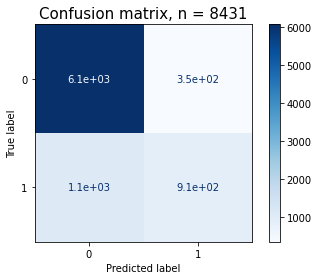

In [14]:
# 임계값 조정 전 confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [15]:
# 임계값 조정 후 confusion matrix
from ipywidgets import interact, fixed
from sklearn.metrics import classification_report

y_pred_proba = pipe.predict_proba(X_val)[:, 1] # 타겟이 1(True)일 확률
def conf_matrix(y_true, y_pred_proba, threshold=0.5):
  y_pred = y_pred_proba > threshold

  fig, ax = plt.subplots()
  pcm = plot_confusion_matrix(pipe, X_val, y_pred,
                              cmap=plt.cm.Blues,
                              ax=ax);
  plt.title(f'Confusion matrix, n = {len(y_pred)}', fontsize=15)
  plt.show()

  print(classification_report(y_true, y_pred))


interact(conf_matrix, y_true=fixed(y_val), y_pred_proba=fixed(y_pred_proba), threshold=(0, 1, 0.01));

# 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상 : 감소

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(객관식) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


In [16]:
import seaborn as sns

def ctrl_estimator(n_estimators=1):
  pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=10, max_depth=None, oob_score=True)
  )

  pipe.fit(X_train, y_train)
  
  y_pred_proba = pipe.predict_proba(X_val)[:, 1]
  sns.displot(y_pred_proba);
        
interact(ctrl_estimator, n_estimators=(1,1000,10));

# n_estimator의 값이 커질 수록 확률값 분포가 다양해진다.

interactive(children=(IntSlider(value=1, description='n_estimators', max=1000, min=1, step=10), Output()), _do…

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 제출하세요.**

In [17]:
### 1. 랜덤 포레스트
from sklearn.metrics import f1_score

pipe_rf = make_pipeline(
    OrdinalEncoder(handle_missing="return_nan"), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth=13, n_estimators=120, random_state=10, n_jobs=-1, oob_score=True)
  )

pipe_rf.fit(X_train, y_train)
y_pred_proba = pipe_rf.predict_proba(X_val)[:, 1] # 타겟이 1(True)일 확률 가져오기
print('훈련 정확도', pipe_rf.score(X_train, y_train))
print('검증 정확도', pipe_rf.score(X_val, y_val))
print('f1 score', f1_score(y_val, pipe_rf.predict(X_val)))

훈련 정확도 0.8894523025828069
검증 정확도 0.8315739532677026
f1 score 0.5520504731861199


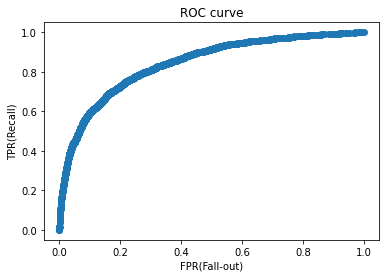

In [18]:
# ROC curve 확인하기
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [19]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr) # 재현율은 최대로, 위양성률은 최소로 하는 데이터의 인덱스 값 찾기
optimal_threshold = thresholds[optimal_idx] # 해당 값의 임계값 가져오기

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 1167 , threshold: 0.2625722614592884


In [20]:
# AUC score 확인
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8428636844613033

In [21]:
# 최적 임계값 적용
y_pred = y_pred_proba > optimal_threshold
print('f1 score', f1_score(y_val, y_pred))

f1 score 0.6135669179058871


In [22]:
### 2. 결정 트리
from sklearn.tree import DecisionTreeClassifier

pipe_dt = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=36, random_state=1)
)

pipe_dt.fit(X_train, y_train)
y_pred_proba = pipe_dt.predict_proba(X_val)[:, 1] # 타겟이 1(True)일 확률 가져오기
print('훈련 정확도: ', pipe_dt.score(X_train, y_train))
print('검증 정확도: ', pipe_dt.score(X_val, y_val))
print('f1 score', f1_score(y_val, pipe_dt.predict(X_val)))

훈련 정확도:  0.8330812798386857
검증 정확도:  0.8206618431977227
f1 score 0.5630057803468207


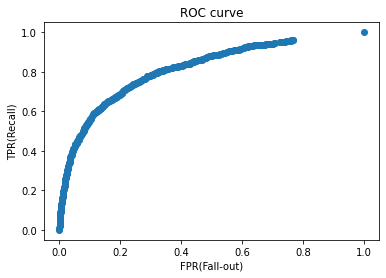

In [23]:
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [24]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr) # 재현율은 최대로, 위양성률은 최소로 하는 데이터의 인덱스 값 찾기
optimal_threshold = thresholds[optimal_idx] # 해당 값의 임계값 가져오기

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 190 , threshold: 0.27906976744186046


In [25]:
# AUC score 확인
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.816833845906326

In [26]:
# 최적 임계값 적용
y_pred = y_pred_proba > optimal_threshold
print('f1 score', f1_score(y_val, y_pred))

f1 score 0.5934295877798703


In [29]:
### 최종 모델 : 랜덤 포레스트 (더 높은 AUC score)
# AUC score는 각 모델에 대하여 재현율은 최대로, 위양성률은 최소로 한 결과임
# 그 결과가 랜덤 포레스트에서 더 우수하게 나왔기 때문에 랜덤 포레스트로 결정
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

last_pipe = make_pipeline(
    OrdinalEncoder(handle_missing="return_nan"), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth=13, n_estimators=120, random_state=10, n_jobs=-1, oob_score=True)
)

last_pipe.fit(X_total, y_total)
y_pred_proba = last_pipe.predict_proba(X_total)[:, 1] # 타겟이 1(True)일 확률 가져오기
print('최종 정확도: ', last_pipe.score(X_total, y_total))

최종 정확도:  0.8837832708639749


In [30]:
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_total, y_pred_proba)

In [31]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr) # 재현율은 최대로, 위양성률은 최소로 하는 데이터의 인덱스 값 찾기
optimal_threshold = thresholds[optimal_idx] # 해당 값의 임계값 가져오기

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 3850 , threshold: 0.2858698606973499


In [32]:
# 최종 모델 학습 후 테스트 셋에 대한 예측 결과
y_pred_proba = last_pipe.predict_proba(X_test)[:, 1] # 타겟이 1(True)일 확률 가져오기
y_test_pred = y_pred_proba > optimal_threshold

In [33]:
# 최종 결과 담은 데이터프레임 생성
d = {'Id':X_test.index, 'vacc_h1n1_f': y_test_pred}
submission = pd.DataFrame(data = d)
submission.head()

,Id,vacc_h1n1_f
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False


In [34]:
# 제출용 파일 생성
# submission.to_csv('submission.csv', index=False)

In [35]:
# !kaggle competitions submit -c prediction-of-h1n1-vaccination -f submission.csv -m "Gyeong ho Ahn, Third Submission(using Random Forest) using threshold"

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.